In [30]:
#@title Dépendences

!pip install qiskit
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt

##Algorithme de Deutch-Josza

Soit $n \in \mathbb{N}$ et $A = \{0,1\}^n$

Considérons $f:A\rightarrow \{0,1\}$ et les ensembles

$B = \left\{x \in A | f(x) = 1 \right\}$
$C = \left\{x \in A | f(x) = 0 \right\}$

Une hypothèse est faite sur la fonction $f$ :

$\left(\left(B = \emptyset\right)\vee\left(C = \emptyset \right)\right)\vee \left( |B| = |C|\right) $

Autrement dit, $f$ est constante ou équilibrée. Le problème de Deutch-Josza consiste à déterminer si elle est l'un ou l'autre. Avec un algorithme itératif classique, il faut dans le cas général analyser la moitié plus une des valeurs de $A$ pour résoudre ce problème ($O(2^{n-1})$). Si la moitié des valeurs est constante et vaut $\alpha$ et que celle suivante vaut aussi $\alpha$ la fonction ne peut pas être équilibrée et est donc constante. Cette complexité est statistiquement pessimiste, puisque si l'on trouve deux valeurs différentes, la fonction est équilibrée.


L'algorithme consiste à créer un circuit quantique dont l'état initial est

$$\vert \psi_{in} \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$

et l'état final sur le premier registre est

$$
            \lvert \psi_{out} \rangle = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
$$



où $y$ est écrit en binaire sur $n$ bits. 

Les $n$ premiers qubits forment le premier registre et le dernier est le deuxième registre de qubits.

On fait alors une mesure sur le premier registre. Ainsi la probabilité de mesurer $0^n$ est $\lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$ qui vaut 1 si $f$ est constante et 0 sinon.

Le circuit suivant permet de réaliser cela. 


 https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html


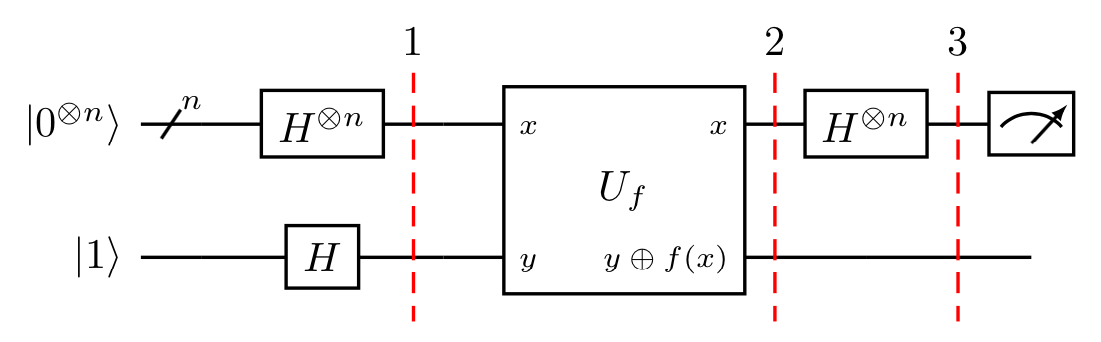

En effet, le qubit du second registre est au niveau de l'étape 1 dans l'état superposé $\vert - \rangle$. L'application d'une porte de Hadamar au premier registre également permet donc de créer l'état 

$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^n-1} \vert x\rangle |- \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$

et l'effet de l'oracle donne donc à l'étape 2 l'état 

\begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert 0 \oplus f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\ 
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}

De la deuxième à la troisième ligne, on remarque que si $f(x)$ est 0 alors $(\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = ( |0\rangle - |1\rangle ) $ et si $f(x)$ vaut 1 alors $(\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = (-1)( |0\rangle - |1\rangle )$.

Enfin, on retrouve l'état de sortie souhaité en appliquant une porte de Hadamar à l'état obtenu, en mettant de côté le terme $(|0\rangle - |1\rangle)$ qui concerne le dernier qubit, et qui ne nous intéresse plus.

Cette preuve de concept est appliquable en pratique à condition de pouvoir fabriquer l'oracle. Appliquons l'algorithme de Deutch-Josza dans un cas simple pour voir comment construire l'oracle. On peut créer l'oracle d'une fonction équilibrée en plaçant des portes CNOT sur tous les qubits du premier registre agissant comme contrôle sur le qubit du deuxième registre. Pour modifier cet oracle à une fonction équilibrée quelconque on peut échanger les valeurs prises avec des portes NOT sur les bons qubits.

Nous chercherons à implémenter Deutch-Josza pour la fonction équilibrée suivante  :   
$f(100) = 0$ \\
$f(010) = 0$ \\
$f(001) = 0$ \\
$f(111) = 0$ \\
$f(101) = 1$ \\
$f(011) = 1$ \\
$f(110) = 1$ \\
$f(000) = 1$ \\



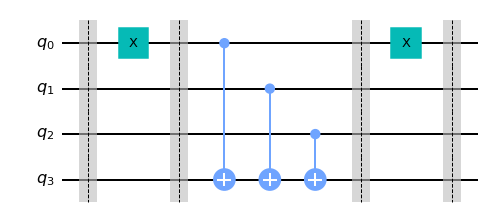

In [30]:
n = 3
oracle_equi = QuantumCircuit(n+1)
str_wrap = "100"
oracle_equi.barrier()
for qubit in range(len(str_wrap)):
    if str_wrap[qubit] == '1':
        oracle_equi.x(qubit)
oracle_equi.barrier()
for qubit in range(n):
    oracle_equi.cx(qubit, n)
oracle_equi.barrier()
for qubit in range(len(str_wrap)):
    if str_wrap[qubit] == '1':
        oracle_equi.x(qubit)
oracle_equi.barrier()

oracle_equi.draw(output='mpl')


L'oracle ci-dessus implémente cette table de vérité. On trouve bien en sortie sur le deuxième registre $|y \oplus f(x)\rangle$ tandis que le premier n'est pas modifié.

Par exemple si y est nul et qu'on envoie 100 au circuit, le premier qubit est renvoyé dans l'état 0 par la porte X et aucun contrôle n'agit sur y, qui vaut 0 en sortie, $\textit{etc}$.

##Implémentation finale

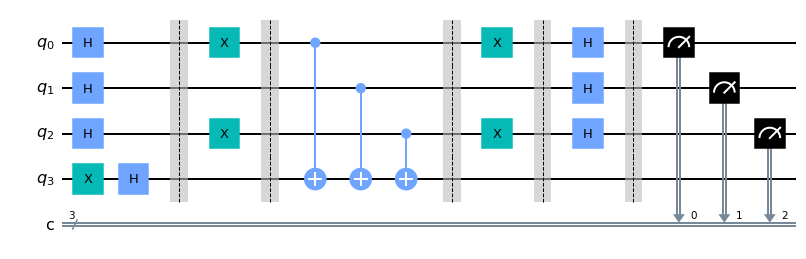

In [25]:

circuit =  QuantumCircuit(n+1,n)
#On met le bit du deuxième registre dans l'état moins (il est initialisé à 0 dans qiskit. On le met à l'état 1 avec NOT puis application d'Hadamar)
circuit.x(n)
circuit.h(n)

#On applique Hadamar au premier registre
for qubit in range(n):
    circuit.h(qubit)

#On applique l'oracle
circuit += oracle_equi

#On applique à nouveau Hadamar
for qubit in range(n):
    circuit.h(qubit)

circuit.barrier()
#On met en place la mesure sur le registre classique
for qubit in range(n):
  circuit.measure(qubit, qubit)
  
circuit.draw(output = 'mpl')


On peut simuler ce circuit grâce à Qiskit et observer les résultats : 

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


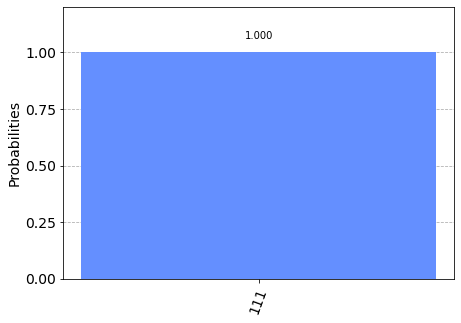

In [31]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Aucune mesure ne vaut 000 donc la fonction est bien équilibrée. 
Sur le simulateur, il suffit d'un seul shot pour savoir si la fonction est équilibrée ou non. Si une mesure vaut 000, alors elles le valent toutes puisque la fonction étant constante la probabilité d'avoir cette mesure vaut 1. En revanche, sur un ordinateur quantique, il faut répéter la mesure puisque des erreurs peuvent avoir lieu.

Par ailleurs, on peut vérifier la probabilité d'obtenir cette mesure selon l'état final. Elle vaut 

$$
            p = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} (-1)^{x \cdot 111}\rvert^2 = \lvert \frac{1}{8}(1(-1-1-1-1) -1(1+1+1+1)) \rvert^2 = \lvert -1 \rvert^2 = 1
$$

Dans le calcul ci dessus la sommation est effectuée en factorisant selon les $f(x)$ nuls et valant 1 selon l'ordre du tableau de valeurs :

$f(100) = 0$ \\
$f(010) = 0$ \\
$f(001) = 0$ \\
$f(111) = 0$ \\
$f(101) = 1$ \\
$f(011) = 1$ \\
$f(110) = 1$ \\
$f(000) = 1$ \\

#Sources

https://quantumcomputing.stackexchange.com/questions/2270/how-to-input-2-qubits-in-2-hadamard-gates

https://www.scottaaronson.com/qclec/17.pdf

https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html